Notebook used to demonstrate the impact of collinearity on DML using OLS as a comparison.

In [2]:
pip install doubleml

     |████████████████████████████████| 116 kB 8.1 MB/s            
Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
from scipy import stats
from scipy.stats import bernoulli
import pandas as pd
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from doubleml import DoubleMLData
from doubleml import DoubleMLPLR

## Duplicate last feature

Lets see what happens if we duplicate the final column of the X features

In [4]:
def gen_features_lastdup(n_samples,n_features, trt_effect,treatment_prob, distribution, noise,seed):
    """
    Function to generate complete duplicate of last feature and weight
    """
    if distribution == 'gaussian':
        X = np.random.randn(n_samples, n_features)
        X = np.column_stack((X,X[:,-1])) #duplicate final column
        D =  bernoulli.rvs(p = treatment_prob,size=n_samples) # treatment var
        dx = np.column_stack((D,X)) #
        weights = np.append(trt_effect,stats.norm.rvs(0, 1, size = n_features))
        weights = np.append(weights,weights[-1]) #add duplicate weight for duplicate feature
        Y = np.dot(dx,weights.T) + np.random.rand()
        if noise >0.0:
            Y += stats.norm.rvs(loc = 0, scale=noise,size=Y.shape)     
    
    elif distribution == 'bernoulli':
        # generate X features
        p_vec = np.random.uniform(size = int(n_features/2))
        x = stats.bernoulli.rvs(p = p_vec, size = [n_samples,int(n_features/2)])
        X = np.repeat(x,2, axis = 1)
        
        #add the treatment var into X data        
        D = bernoulli.rvs(p = treatment_prob,size=n_samples) # treatment var
        dx = np.column_stack((D,X))
        #generate weights
        weights = np.append(trt_effect,stats.norm.rvs(0, 1, size = int(n_features/2)))
        weights = np.append(weights,weights[1:])
        Y = np.dot(dx,weights.T) + np.random.rand()
        #implement noise for bernoulli with noise = p(flip bit)
        if noise >0.0:
            #Y_multiplier = [-1 if random.random() < noise else 1 for i in Y]
            #Y = Y * Y_multiplier
            Y += stats.norm.rvs(loc = 0, scale=noise,size=Y.shape)  
            
    else:
        print("Not a valid distribution")
    
    return X,dx,weights, Y, D

In [5]:
#define simulation parameters
trt_effect = 0.5 #float
num_runs = [1,2,3] #array of integers
data_distribution = ["bernoulli","gaussian"] #gaussian/bernoulli
num_samples = [1000000] #array of integers
num_feats = [10] #array of integers
noises = [0] #array of floats. normally distributed noise centered around 0. This value changes the std
trt_prob = [0.9]
seed = 123

#create empty df to hold 
df = pd.DataFrame(columns=['Run', 'OLS','OLS_LB','OLS_UB','std_err','DML','DML_err', 'DML_LB','DML_UB','DML_t_stat','num_samples','distribution','num_features','noise'])

############################
#### Execute simulation ####
############################
for run in num_runs:
    for feature_num in num_feats:
        for samples in num_samples:
            for dist in data_distribution:
                for noise in noises:
                #generate data
                    X,dx, weights,Y,D = gen_features_lastdup(n_samples=samples,n_features=feature_num,trt_effect=trt_effect,treatment_prob=trt_prob,distribution=dist,noise=noise, seed=seed)
                    ######################################################################    
                    # OLS --------------------------------------------------     
                    ######################################################################
                    OLS = sm.OLS(Y,dx)
                    results = OLS.fit()        
                    
                    ####
                    ##Add confidence interval for OLS
                    ols_LB = results.conf_int(alpha=0.05, cols=None)[0][0]
                    ols_UB = results.conf_int(alpha=0.05, cols=None)[0][1]            
                    std_err = results.bse[0]
                    
                    ######################################################################
                    # DML package                      -----------------------------------     
                    ######################################################################
                    # DML ml_m_rf as classifier        -----------------------------------     
                    ######################################################################
                    dml_data = DoubleMLData.from_arrays(X, Y, D)
                    
                    ml_g_rf = RandomForestRegressor(n_estimators=100,max_depth=10, n_jobs = -1)
                    ml_m_rf = RandomForestClassifier(n_estimators=100,max_depth=10, n_jobs = -1)
                    
                    dml_plr_tree = DoubleMLPLR(dml_data, ml_g = ml_g_rf, ml_m = ml_m_rf)
                    #estimation
                    dml_plr_tree.fit()

                    row = [run,results.params[0],ols_LB,ols_UB,std_err, dml_plr_tree.coef,dml_plr_tree.se, dml_plr_tree.confint().iloc[0][0],dml_plr_tree.confint().iloc[0][1],dml_plr_tree.t_stat, samples, dist, feature_num, noise]
                    df.loc[len(df)] = row

In [6]:
df

,Run,OLS,OLS_LB,OLS_UB,std_err,DML,DML_err,DML_LB,DML_UB,DML_t_stat,num_samples,distribution,num_features,noise
0,1,0.584930,0.584663,0.585198,0.000137,[0.5000002722476956],[4.3980002537639163e-07],0.499999,0.500001,[1136880.9536101848],1000000,bernoulli,10,0
1,1,0.665071,0.664963,0.665179,0.000055,[0.5051846721065018],[0.00402314919092977],0.497299,0.513070,[125.56946017449354],1000000,gaussian,10,0
2,2,0.580524,0.579942,0.581105,0.000297,[0.4999989828558172],[4.0823017841554987e-07],0.499998,0.500000,[1224796.7183524906],1000000,bernoulli,10,0
3,2,1.163267,1.162834,1.163701,0.000221,[0.49991952927447336],[0.0034103185197221476],0.493235,0.506604,[146.5902748917435],1000000,gaussian,10,0
4,3,0.863922,0.863063,0.864781,0.000438,[0.49999910112927465],[4.5093872258351534e-07],0.499998,0.500000,[1108796.1092910427],1000000,bernoulli,10,0
5,3,0.670511,0.670400,0.670623,0.000057,[0.5017379960416264],[0.005452937145584017],0.491050,0.512426,[92.01242975044224],1000000,gaussian,10,0


In [7]:
df[['DML','DML_err','DML_t_stat']] = df[['DML','DML_err','DML_t_stat']].apply(lambda x: x.str[0])

Text(0.5, 1.0, '1M samples, 11 features (last duplicated)')

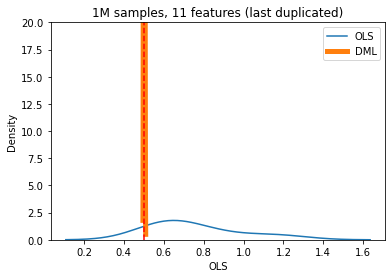

In [8]:
sns.kdeplot(df.OLS, label = 'OLS')
sns.kdeplot(df.DML, label = 'DML', linewidth='5')
plt.axvline(trt_effect, color = 'r', linestyle='--')
plt.ylim(0,20)
plt.legend()
plt.title("1M samples, 11 features (last duplicated)")

We can see that the colinear feature throughs off the OLS prediction to be 0.65 instead of 0.5 but the DML captures it with high precision.

## Duplicate all features

What happens when we add even more colinear features?

In [9]:
def gen_features_doublefeats(n_samples,n_features, trt_effect,treatment_prob, distribution, noise,seed):
    """º
    generates complete duplicate features and weights of X features
    """
    if distribution == 'gaussian':
        x = np.random.randn(n_samples, n_features)
        #create identical features
        X = np.repeat(x,2, axis = 1)
        D =  bernoulli.rvs(p = treatment_prob,size=n_samples) # treatment var
        dx = np.column_stack((D,X))
        weights = np.append(trt_effect,stats.norm.rvs(0, 1, size = n_features))
        weights = np.append(weights,weights[1:])#create duplicate weights
        Y = np.dot(dx,weights.T) + np.random.rand()
        if noise >0.0:
            Y += stats.norm.rvs(loc = 0, scale=noise,size=Y.shape)     
    
    elif distribution == 'bernoulli':
        # generate X features
        p_vec = np.random.uniform(size = int(n_features/2))
        x = stats.bernoulli.rvs(p = p_vec, size = [n_samples,int(n_features/2)])
        X = np.repeat(x,2, axis = 1)
        
        #add the treatment var into X data        
        D = bernoulli.rvs(p = treatment_prob,size=n_samples) # treatment var
        dx = np.column_stack((D,X))
        #generate weights
        weights = np.append(trt_effect,stats.norm.rvs(0, 1, size = int(n_features/2)))
        weights = np.append(weights,weights[1:])
        Y = np.dot(dx,weights.T) + np.random.rand()
        #implement noise for bernoulli with noise = p(flip bit)
        if noise >0.0:
            #Y_multiplier = [-1 if random.random() < noise else 1 for i in Y]
            #Y = Y * Y_multiplier
            Y += stats.norm.rvs(loc = 0, scale=noise,size=Y.shape)  
            
    else:
        print("Not a valid distribution")
    
    return X,dx,weights, Y, D

In [10]:
#define simulation parameters
trt_effect = 0.5 #float
num_runs = [1,2,3] #array of integers
data_distribution = ["bernoulli","gaussian"] #gaussian/bernoulli
num_samples = [1000000] #array of integers
num_feats = [10] #array of integers
noises = [0] #array of floats. normally distributed noise centered around 0. This value changes the std
trt_prob = [0.9]
seed = 123

#create empty df to hold 
df2 = pd.DataFrame(columns=['Run', 'OLS','OLS_LB','OLS_UB','std_err','DML','DML_err', 'DML_LB','DML_UB','DML_t_stat','num_samples','distribution','num_features','noise'])

############################
#### Execute simulation ####
############################
for run in num_runs:
    for feature_num in num_feats:
        for samples in num_samples:
            for dist in data_distribution:
                for noise in noises:
                #generate data
                    X,dx, weights,Y,D = gen_features_doublefeats(n_samples=samples,n_features=feature_num,trt_effect=trt_effect,treatment_prob=trt_prob,distribution=dist,noise=noise, seed=seed)
                    ######################################################################    
                    # OLS --------------------------------------------------     
                    ######################################################################
                    OLS = sm.OLS(Y,dx)
                    results = OLS.fit()        
                    
                    ####
                    ##Add confidence interval for OLS
                    ols_LB = results.conf_int(alpha=0.05, cols=None)[0][0]
                    ols_UB = results.conf_int(alpha=0.05, cols=None)[0][1]            
                    std_err = results.bse[0]
                    
                    ######################################################################
                    # DML package                      -----------------------------------     
                    ######################################################################
                    # DML ml_m_rf as classifier        -----------------------------------     
                    ######################################################################
                    dml_data = DoubleMLData.from_arrays(X, Y, D)
                    
                    ml_g_rf = RandomForestRegressor(n_estimators=100,max_depth=10, n_jobs = -1)
                    ml_m_rf = RandomForestClassifier(n_estimators=100,max_depth=10, n_jobs = -1)
                    
                    dml_plr_tree = DoubleMLPLR(dml_data, ml_g = ml_g_rf, ml_m = ml_m_rf)
                    #estimation
                    dml_plr_tree.fit()

                    row = [run,results.params[0],ols_LB,ols_UB,std_err, dml_plr_tree.coef,dml_plr_tree.se, dml_plr_tree.confint().iloc[0][0],dml_plr_tree.confint().iloc[0][1],dml_plr_tree.t_stat, samples, dist, feature_num, noise]
                    df2.loc[len(df2)] = row

In [11]:
df2

,Run,OLS,OLS_LB,OLS_UB,std_err,DML,DML_err,DML_LB,DML_UB,DML_t_stat,num_samples,distribution,num_features,noise
0,1,0.859598,0.858942,0.860255,0.000335,[0.5000003121696383],[4.5843731455880385e-07],0.499999,0.500001,[1090662.3354838258],1000000,bernoulli,10,0
1,1,1.158288,1.157858,1.158718,0.000220,[0.5054918927680976],[0.0047811979754643725],0.496121,0.514863,[105.72494495357135],1000000,gaussian,10,0
2,2,0.968499,0.967464,0.969535,0.000528,[0.4999990433320999],[4.212488324551266e-07],0.499998,0.500000,[1186944.6389156748],1000000,bernoulli,10,0
3,2,0.513565,0.513556,0.513574,0.000005,[0.5008744960722427],[0.0025255939258660024],0.495924,0.505825,[198.31948871214422],1000000,gaussian,10,0
4,3,0.621158,0.620530,0.621786,0.000320,[0.5000000906817944],[5.115317553344321e-07],0.499999,0.500001,[977456.6006266836],1000000,bernoulli,10,0
5,3,1.006941,1.006609,1.007273,0.000169,[0.4977673540380183],[0.003326540124458384],0.491247,0.504287,[149.63515707451842],1000000,gaussian,10,0


In [12]:
df2[['DML','DML_err','DML_t_stat']] = df2[['DML','DML_err','DML_t_stat']].apply(lambda x: x.str[0])

Text(0.5, 1.0, '1M samples, 20 features (10 original then duplicated)')

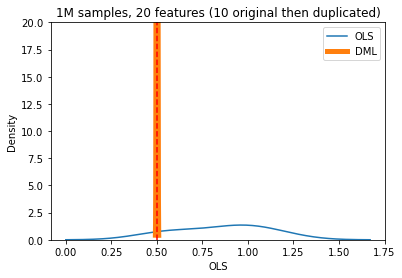

In [13]:
sns.kdeplot(df2.OLS, label = 'OLS')
sns.kdeplot(df2.DML, label = 'DML', linewidth='5')
plt.axvline(trt_effect, color = 'r', linestyle='--')
plt.ylim(0,20)
plt.legend()
plt.title("1M samples, 20 features (10 original then duplicated)")

Can see that with more collinear features OLS estimate runs further away from the real (0.5) but DoubleML keeps a tight estimate of the coeffient